<img align="left" src="media/Assets&ArchHeader.jpeg">

#  Operationalize a Scikit-learn Model with Db2 v11.5	

Traditional scoring of machine learning models with data stored in a database often involves transferring the scoring data to a deployment system where the trained model is stored.  This can cause major challenges such as data transfer costs or data security requirements that can limit the kind or amount of data transferred from the database, such as personal identifiable information. Additionally, hardware and software roadblocks can ultimately prevent the transfer of large amounts of scoring data.

In this workshop we will develop a machine learning pipeline externally (i.e. on a local Jupyter notebook) and deploy it to Db2 for in-database scoring via SQL commands.

This solution allows users such as business analysts using SQL-based tools and applications to execute the machine learning pipeline by simply querying the Db2 database. 

This process ultimately keeps your scoring data secure and reduces data transfer latency, required compute power, complexity, and cost.

**Prerequisites**: If you are unfamiliar with the Jupyter Notebook environment, it is recommended to have gone through the [An Introduction to Jupyter Notebooks](./An_Introduction_to_Jupyter_Notebooks.ipynb) lab first

## Problem Statement

Consider we are on a plane heading towards our destination. We want to determine if the flight will be delayed arriving or not after it leaves the origin airport (binary classification):
* A delayed flight will be a flight that arrives late at its destination
* If the flight has any delays from its departure, but still arrives to its destination on time, it will not be considered a delayed flight
* A *canceled* flight is not a delayed flight as it never left nor arrived to its destination for whatever reason
* A *diverted* flight is not a delayed flight as it was diverted from its destination

To solve this problem, we will use historical US flight data from 2009-2018. We will then deploy our model to Db2 and make predictions on "new" data from 2020.

## Imports and Connection to Db2

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np

# Model building
from sklearn.model_selection import train_test_split # Train-test split
from sklearn.impute import SimpleImputer # Missing values imputation
from sklearn.preprocessing import OneHotEncoder, StandardScaler # Feature scaling and one-hot encoding
from sklearn.linear_model import LogisticRegression # Model
from sklearn.metrics import classification_report, confusion_matrix, f1_score # Model evaluation
from joblib import dump #Saving deployment assets

from sklearn.base import BaseEstimator, TransformerMixin # For creating transformation pipelines
from sklearn.pipeline import Pipeline # For creating transformation pipelines
from sklearn.compose import ColumnTransformer # For creating transformation pipelines

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(12,8)})
%config InlineBackend.figure_format = 'retina'

First load the Db2 magic functions and make a connection to our Db2 database.

In [2]:
%run db2.ipynb

Db2 Extensions Loaded.


In [3]:
%run connectiondb2ml.ipynb

Connection successful.


In [4]:
%sql option maxrows -1 display pandas

# Part I. Pipeline Development

## Read in Data

First we will read in our training data. Our training data contains historical flight data from 2009-2018 and contains the following data:
- `YEAR`: The year of the flight
- `QUARTER`: The yearly quarter
- `MONTH`: The month of the flight
- `DAYOFMONTH`: The day of the flight
- `DAYOFWEEK`: The day of the week the flight took place
- `UNIQUECARRIER`: The abbreviation code of the airline
- `ORIGIN`: The airport code of the departure airport
- `DEST`: The airport code of the arrival airport
- `CRSDEPTIME`: The scheduled departure time of the flight in the reservation system
- `DEPTIME`: The actual departure time of the flight
- `DEPDELAY`: The difference between the actual and scheduled departure times (minutes)
- `DEPDEL15`: Departure delay > 15 mins?
- `TAXIOUT`: Taxi out time (minutes)
- `WHEELSOFF`: Wheels of time (local time)
- `CRSARRTIME`: The scheduled arrival time of the flight in the reservation system
- `ARRTIME`: The actual arrival time of the flight
- `ARRDELAY`: The difference between the actual and scheduled arrival times (minutes)
- `CRSELAPSEDTIME`: The scheduled elapsed time of the flight in the reservation system
- `AIRTIME`: Flight time (minutes)
- `DISTANCEGROUP`: 250 mile distance interval group

![](media/ontime.png)

**Figure 1:** This figure shows the stages of a flight as described in the dataset

In [5]:
query = %sql SELECT * FROM ONTIME.TRAIN
df = pd.DataFrame(query)

In [6]:
df.head()

,YEAR,QUARTER,MONTH,DAYOFMONTH,DAYOFWEEK,UNIQUECARRIER,ORIGIN,DEST,CRSDEPTIME,DEPTIME,DEPDELAY,DEPDEL15,TAXIOUT,WHEELSOFF,CRSARRTIME,ARRTIME,ARRDELAY,CRSELAPSEDTIME,AIRTIME,DISTANCEGROUP
0,2013,1,1,25,5,MQ,RDU,LGA,1100,1057,-3.0,0.0,12,1109,1230,1214,-16.0,90,62,2
1,2016,4,11,28,1,WN,BWI,PVD,1040,1034,-6.0,0.0,12,1046,1150,1138,-12.0,70,50,2
2,2012,2,4,26,4,US,PHX,ATL,910,905,-5.0,0.0,35,940,1554,1556,2.0,224,186,7
3,2010,2,6,17,4,EV,MEI,ATL,610,605,-5.0,0.0,4,609,824,806,-18.0,74,50,2
4,2016,2,4,1,5,DL,DAY,ATL,1032,1025,-7.0,0.0,17,1042,1209,1205,-4.0,97,78,2


In [7]:
print('The dataset has',df.shape[0],'rows and',df.shape[1],'columns.')

The dataset has 1000000 rows and 20 columns.


In [8]:
# Let's look at some summary statistics
df.describe()

,YEAR,QUARTER,MONTH,DAYOFMONTH,DAYOFWEEK,CRSDEPTIME,DEPTIME,DEPDELAY,DEPDEL15,TAXIOUT,WHEELSOFF,CRSARRTIME,ARRTIME,ARRDELAY,CRSELAPSEDTIME,AIRTIME,DISTANCEGROUP
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,999937.000000,999937.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,999960.000000,1000000.000000,1000000.000000,1000000.000000
mean,2013.193454,2.454007,6.362631,15.740650,3.936586,1325.589780,1332.387942,8.902103,0.180074,15.900501,1355.288523,1494.160152,1479.347530,4.669345,136.876648,109.661863,3.625980
std,2.784399,1.104170,3.394361,8.777538,1.989779,473.690848,486.288007,36.099259,0.384250,9.226515,487.585689,494.197406,513.180123,38.629338,73.472559,70.653527,2.338014
min,2009.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-62.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-103.000000,18.000000,7.000000,1.000000
25%,2011.000000,1.000000,3.000000,8.000000,2.000000,920.000000,925.000000,-5.000000,0.000000,10.000000,939.000000,1113.000000,1103.000000,-13.000000,84.000000,58.000000,2.000000
50%,2013.000000,2.000000,6.000000,16.000000,4.000000,1320.000000,1326.000000,-2.000000,0.000000,14.000000,1340.000000,1519.000000,1512.000000,-4.000000,118.000000,90.000000,3.000000
75%,2016.000000,3.000000,9.000000,23.000000,6.000000,1724.000000,1733.000000,7.000000,0.000000,19.000000,1747.000000,1911.000000,1911.000000,8.000000,167.000000,139.000000,5.000000
max,2018.000000,4.000000,12.000000,31.000000,7.000000,2359.000000,2400.000000,1767.000000,1.000000,232.000000,2400.000000,2400.000000,2400.000000,1794.000000,700.000000,703.000000,11.000000


## Data Preparation

### Create Target variable
We will use the `ARRDELAY` variable to create our target variable `FLIGHTSTATUS`:
- 0 = on time or early
- 1 = delayed

Let's first check for any missing values in this column

In [9]:
# Count the number of missing values
df['ARRDELAY'].isna().sum()

40

Lets investigate why these values are NA

In [10]:
# Create a temporary dataframe that includes rows where "ARRDELAY" is missing
tmp = df[df['ARRDELAY'].isna()]
tmp[['CRSARRTIME','ARRTIME','ARRDELAY']].head(10)

,CRSARRTIME,ARRTIME,ARRDELAY
4019,2100,2100,NaN
48315,1933,1933,NaN
88090,1629,1629,NaN
128435,1700,1700,NaN
144124,1420,1420,NaN
147435,752,752,NaN
190007,1203,1203,NaN
205705,1156,1156,NaN
222600,1855,1855,NaN
259968,1515,1515,NaN


We can see that these flights infact arrived on time: `CRSARRTIME` = `ARRTIME`. So we can replace these missing values in `ARRDELAY` with 0

In [11]:
# Fill in missing values with 0
df['ARRDELAY']=df['ARRDELAY'].fillna(0)

We are now ready to create our target variable

In [12]:
# Create our target variable:
# 0 = on time or early
# 1 = delayed
target = 'FLIGHTSTATUS'
status = []
for val in df['ARRDELAY']:
    if val <=0:
        status.append(0)
    else:
        status.append(1) 

df[target] = status

In [13]:
# Let's look at the distribution of our target variable
df[target].value_counts(normalize=True)

0    0.624554
1    0.375446
Name: FLIGHTSTATUS, dtype: float64

We can see our dataset is slightly imbalanced with 62% of records being flights that are on time or early, and 38% of flights being delayed

In [14]:
df.head()

,YEAR,QUARTER,MONTH,DAYOFMONTH,DAYOFWEEK,UNIQUECARRIER,ORIGIN,DEST,CRSDEPTIME,DEPTIME,DEPDELAY,DEPDEL15,TAXIOUT,WHEELSOFF,CRSARRTIME,ARRTIME,ARRDELAY,CRSELAPSEDTIME,AIRTIME,DISTANCEGROUP,FLIGHTSTATUS
0,2013,1,1,25,5,MQ,RDU,LGA,1100,1057,-3.0,0.0,12,1109,1230,1214,-16.0,90,62,2,0
1,2016,4,11,28,1,WN,BWI,PVD,1040,1034,-6.0,0.0,12,1046,1150,1138,-12.0,70,50,2,0
2,2012,2,4,26,4,US,PHX,ATL,910,905,-5.0,0.0,35,940,1554,1556,2.0,224,186,7,1
3,2010,2,6,17,4,EV,MEI,ATL,610,605,-5.0,0.0,4,609,824,806,-18.0,74,50,2,0
4,2016,2,4,1,5,DL,DAY,ATL,1032,1025,-7.0,0.0,17,1042,1209,1205,-4.0,97,78,2,0


#### Drop unneeded columns

We can drop the following columns:
- `ARRDELAY`: Will use the target variable instead
- `ARRTIME`: Will use the CRSArrTime instead

In [15]:
# Drop columns that are no longer needed
cols_to_drop=['ARRDELAY','ARRTIME']
df=df.drop(cols_to_drop,axis=1)

In [16]:
df.head()

,YEAR,QUARTER,MONTH,DAYOFMONTH,DAYOFWEEK,UNIQUECARRIER,ORIGIN,DEST,CRSDEPTIME,DEPTIME,DEPDELAY,DEPDEL15,TAXIOUT,WHEELSOFF,CRSARRTIME,CRSELAPSEDTIME,AIRTIME,DISTANCEGROUP,FLIGHTSTATUS
0,2013,1,1,25,5,MQ,RDU,LGA,1100,1057,-3.0,0.0,12,1109,1230,90,62,2,0
1,2016,4,11,28,1,WN,BWI,PVD,1040,1034,-6.0,0.0,12,1046,1150,70,50,2,0
2,2012,2,4,26,4,US,PHX,ATL,910,905,-5.0,0.0,35,940,1554,224,186,7,1
3,2010,2,6,17,4,EV,MEI,ATL,610,605,-5.0,0.0,4,609,824,74,50,2,0
4,2016,2,4,1,5,DL,DAY,ATL,1032,1025,-7.0,0.0,17,1042,1209,97,78,2,0


In [17]:
print('The dataset now has',df.shape[0],'rows and',df.shape[1],'columns.')

The dataset now has 1000000 rows and 19 columns.


### Train-Test Split

Before we continue with further data preparation steps, we will first split our dataset into a training and test set using an 80/20 split. We will use our training data to develop our model and our test set to evaluate the model's performance.

In [18]:
# Train test split
X = df.drop(target,axis=1)
y = df[target]

# # 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [19]:
print('The training dataset has',X_train.shape[0],'rows and',X_train.shape[1],'columns.')

The training dataset has 800000 rows and 18 columns.


In [20]:
print('The test dataset has',X_test.shape[0],'rows and',X_test.shape[1],'columns.')

The test dataset has 200000 rows and 18 columns.


### Missing Values

Most machine learning algorithms cannot work with missing values. Therefore, it is important to identify any missing values and then to impute (i.e., replace) any missing values in our dataset.

In [21]:
# Calculate percentage of missing values and show top 10 columns with most missing values
percent_missing = X_train.isna().sum() * 100 / len(X_train)
percent_missing.sort_values(ascending=False, inplace=True)
percent_missing[:10]

DEPDEL15         0.006375
DEPDELAY         0.006375
DISTANCEGROUP    0.000000
DEST             0.000000
QUARTER          0.000000
MONTH            0.000000
DAYOFMONTH       0.000000
DAYOFWEEK        0.000000
UNIQUECARRIER    0.000000
ORIGIN           0.000000
dtype: float64

There are missing values, so imputation is required

#### DepDelay
Let's do some missing values investigation with `DEPDELAY` and `DEPDEL15`

In [22]:
# Count the number of missing values
print('Number of missing values in DEPDELAY column: ',df['DEPDELAY'].isna().sum())
print('Number of missing values in DEPDEL15 column: ',df['DEPDEL15'].isna().sum())

Number of missing values in DEPDELAY column:  63
Number of missing values in DEPDEL15 column:  63


In [23]:
# Create a temporary dataframe that includes rows where "DEPDELAY" is missing
tmp = df[df['DEPDELAY'].isna()]
tmp[['CRSDEPTIME','DEPTIME','DEPDELAY','DEPDEL15']].head(10)

,CRSDEPTIME,DEPTIME,DEPDELAY,DEPDEL15
4556,1430,1430,NaN,NaN
15478,809,809,NaN,NaN
58348,602,602,NaN,NaN
60887,1735,1735,NaN,NaN
65798,830,830,NaN,NaN
70239,2015,2015,NaN,NaN
72678,1427,1427,NaN,NaN
84632,630,630,NaN,NaN
125797,1830,1830,NaN,NaN
128435,1510,1510,NaN,NaN


We can see that these flights infact departed on time: `CRSDEPTIME` = `DEPTIME`. So we can replace these missing values in `DEPDELAY` and `DEPDEL15` with 0. 

We will also drop the feature `DEPTIME` from our data set as it is highly correlated to `DEPDELAY` (i.e. we can use the values in `CRSDEPTIME` and `DELDELAY` to obtain the values in `DEPTIME`)

In [24]:
# Drop DEPTIME from our training and test sets
X_train=X_train.drop(['DEPTIME'],axis=1)
X_test=X_test.drop(['DEPTIME'],axis=1)

We will perform our data transformations by wrapping them in the scikit-learn Pipeline construct - this will allow us to chain our other data transformations together later on and combine them with our ML model to simplify the code required.

![](media/pipeline.png)

**Figure 2:** This image shows how we are using scikit-learn's Pipeline and ColumnTransformer constructs to build a machine learning pipeline that performs data transformations in parallel, concatenates the results, and feeds the transformed data to the ML model. Each of the dashed black boxes represents a sub-pipeline that handles a particular transformation on a subset of our dataset.

We will first create a pipeline for the missing values imputer - note that we have not included `DEPDELAY` in this pipeline. This is because we also want to perform feature scaling on it, so we will impute that feature in a following step.

In [25]:
# Pipeline for missing values imputation
features_to_impute = ['DEPDEL15']
missing_vals_imputer = Pipeline( steps = [
    ( 'imputer', SimpleImputer(strategy='constant',fill_value=0) )
])

### Convert Time Values
We will convert the timestamp values in `CRSDepTime`,`WheelsOff`, and `CRSArrTime` to a categorical value split into 4 quarters of the day. We will split `CRSElapsedTime` into 30 min segments. To incorporate this into a Pipeline construct, we first need to create a custom class that performs this transformation.

In [26]:
#Custom transformer that breaks time values into categorical values
class TimeTransformer( BaseEstimator, TransformerMixin ):
    #Class constructor method - takes no inputs, so nothing to do
    def __init__(self):
        return None
        
    #Return self nothing else to do here
    def fit( self, X, y = None  ):
        return self
    
    #Transformer method we wrote for this transformer 
    # Converts 24hr features into 4 quarters of the day, splits elapsed time into 30min segments
    def transform(self, X , y = None ):
        X['CRSDEPTIME'] = np.ceil(X['CRSDEPTIME']/600).apply(int)
        X['WHEELSOFF'] = np.ceil(X['WHEELSOFF']/600).apply(int) 
        X['CRSARRTIME'] = np.ceil(X['CRSARRTIME']/600).apply(int)
        X['CRSELAPSEDTIME']=np.ceil(X['CRSELAPSEDTIME']/30).apply(int)
        
        return X.values

In [27]:
# Create a pipeline that converts our time values using the custom transformer we just wrote
time_features = ['CRSDEPTIME','WHEELSOFF','CRSARRTIME','CRSELAPSEDTIME']
time_vals_converter = Pipeline( steps = [
    ( 'time_transformer', TimeTransformer())
])

### Feature Scaling
We will scale our continuous numerical columns: `AirTime`,`TaxiOut`,`DepDelay`.

Most machine learning algorithms do not perform well when the numerical attributes in the data have very different scales (i.e., large range of possible values). It is important to make sure that the numerical features in our dataset have similar scales. A standardized value z of an input feature x is calculated as:

z = (x - u) / s

where u is the mean of the training samples and s is the standard deviation of the training samples.

In [28]:
# Scale continuous numerical columns
features_to_scale=['AIRTIME','TAXIOUT','DEPDELAY']
feature_scaler = Pipeline( steps = [
    ( 'imputer', SimpleImputer(strategy='constant',fill_value=0)), # Imputation - DEPDELAY has missing values
    ( 'scaler', StandardScaler())
])

### One-Hot Encoding

The values in `UNIQUECARRIER`, `ORIGIN`, and `DEST` need to be converted into categorical columns

Most machine learning algorithms prefer to work with numbers rather than text values. A common solution is to create one binary attribute *per category*: one attribute equal to 1 when the category is “LAX” (and 0 otherwise), another attribute equal to 1 when the category is “JFK” (and 0 otherwise), and so on. This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold).

In [29]:
# Calculate number of unique values in each of these columns
print('Number of unique values in UNIQUECARRIER:', X_train['UNIQUECARRIER'].nunique())
print('Number of unique values in ORIGIN:', X_train['ORIGIN'].nunique())
print('Number of unique values in DEST:', X_train['DEST'].nunique())

Number of unique values in UNIQUECARRIER: 23
Number of unique values in ORIGIN: 367
Number of unique values in DEST: 366


Clearly, we can't apply one-hot encoding directly to these columns as we would be adding >750 new columns! Instead we will select the top 10 most common occurences in these columns as our labels. Again to do this, we need to create a custom class that will first identify the top 10 most common occurences, and then will transform the values not in those top 10 lists to "Other_X" (e.g. Other_Airline).

In [30]:
#Custom transformer that reduces the number of unique values
class ReduceUnique( BaseEstimator, TransformerMixin ):
    #Class constructor method - takes no inputs, so nothing to do
    def __init__(self):
        return None
        
    #Fit method - find the top 10 most common occurrences in each of the 3 columns
    def fit( self, X, y = None  ):
        self._top_10_airlines = X_train['UNIQUECARRIER'].value_counts().index[:10].tolist()
        self._top_10_origin = X_train['ORIGIN'].value_counts().index[:10].tolist()
        self._top_10_dest = X_train['DEST'].value_counts().index[:10].tolist()
        return self
    
    #Transformer method - convert values not in the top 10 lists to "Other_X"
    def transform(self, X , y = None ):
        X['UNIQUECARRIER'] = np.where(~X['UNIQUECARRIER'].isin(self._top_10_airlines),
                                      'Other_Airline', X['UNIQUECARRIER'])
        X['ORIGIN'] = np.where(~X['ORIGIN'].isin(self._top_10_origin),'Other_Origin', X['ORIGIN'])
        X['DEST'] = np.where(~X['DEST'].isin(self._top_10_dest),'Other_Dest', X['DEST'])
        
        return X.values 

After having applied this `ReduceUnique` transformer to our columns, we can now perform one-hot encoding as we now only replace the 3 original columns with 11+11+11=33 new columns.

In [31]:
# Perform one-hot encoding
features_to_encode=['UNIQUECARRIER','ORIGIN','DEST']
feature_encoder = Pipeline( steps = [
    ( 'reduceunique', ReduceUnique()), # First reduce the number of unique values
    ('encoder',OneHotEncoder(handle_unknown='ignore')) # Perform one-hot encoding
])

## Combine our transformers into a single data transformation pipeline

The ColumnTransformer construct allows us to perform our transformations *in parallel* improving the overall execution time of our pipeline. It does so by applying different transformers to different subsets of the whole input data and concatenating the results. 

In [32]:
transform_pipeline=ColumnTransformer([
    ('imputer',missing_vals_imputer,features_to_impute), # Missing values imputation
    ('time_vals_converter',time_vals_converter,time_features), # 24hr time values conversion
    ('feature_scaler', feature_scaler,features_to_scale ), # Feature scaling
    ('feature_encoder', feature_encoder,features_to_encode ) # One-hot encoding
],remainder='passthrough',verbose=True)

![](media/pipeline.png)

**Figure 2:** This image shows how we are using scikit-learn's Pipeline and ColumnTransformer constructs to build a machine learning pipeline that performs data transformations in parallel, concatenates the results, and feeds the transformed data to the ML model.

## Model Training

### Logistic Regression

Logistic Regression (also called Logit Regression) is commonly used to estimate the probability that an instance belongs to a particular class (e.g., what is the probability that you will pass your exam?). If the estimated probability is greater than 50%, then the model predicts that the instance belongs to that class (called the positive class, labeled “1”), and otherwise it predicts that it does not (i.e., it belongs to the negative class, labeled “0”). This makes it a binary classifier.

We will train a logistic regression model using the default values and setting the `class_weight` parameter to "balanced" due to our imbalanced training dataset.

![](media/Exam_pass_logistic_curve.jpeg)

**Figure 3:** A sample logistic regression model. The blue line shows the fitted logit function, and the black dots represent the input training data. Note that for points where the probability is greater than 50%, the predicted class is 1, and 0 otherwise. This model predicts that if you study for 2.75 hrs or longer, you will pass your exam.

In [33]:
# Create our final ML pipeline by adding our model to the data transformation pipeline
full_pipeline = Pipeline( steps = [
    ('transformation_pipeline', transform_pipeline), # Data transformations
    ( 'model', LogisticRegression(random_state=42,class_weight='balanced')) # Logistic Regression model
],verbose=True)

In [34]:
#Perform data transformations and fit our model to the transformed training data
trained_pipeline = full_pipeline.fit(X_train,y_train)

[ColumnTransformer] ....... (1 of 5) Processing imputer, total=   0.0s
[ColumnTransformer]  (2 of 5) Processing time_vals_converter, total=   1.6s
[ColumnTransformer]  (3 of 5) Processing feature_scaler, total=   0.1s
[ColumnTransformer]  (4 of 5) Processing feature_encoder, total=   3.4s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[Pipeline]  (step 1 of 2) Processing transformation_pipeline, total=   5.6s
[Pipeline] ............. (step 2 of 2) Processing model, total=  14.9s


In [35]:
#Make predictions on our test set to compare it against the true values
y_pred = trained_pipeline.predict(X_test)

We will use the F1 score (harmonic mean of Precision and Recall) as our metric for evaluating model performance. An F1-Score of 1.0, indicates perfect precision and recall, and the lowest possible value is 0, if either the precision or the recall is zero.

Precision is the number of true positive results divided by the number of all positive results, including those not identified correctly, and the recall is the number of true positive results divided by the number of all samples that should have been identified as positive.

The F1 score can be expressed as

$\frac{TP}{TP +\frac{1}{2}(FP+FN)}$,

where TP is the number of true positives, FP is the number of false positives, and FN is the number of false negatives

In [36]:
# Let's evaluate the model performance
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87    125138
           1       0.79      0.73      0.76     74862

    accuracy                           0.83    200000
   macro avg       0.82      0.81      0.81    200000
weighted avg       0.83      0.83      0.83    200000



Model F1 Score: 0.761


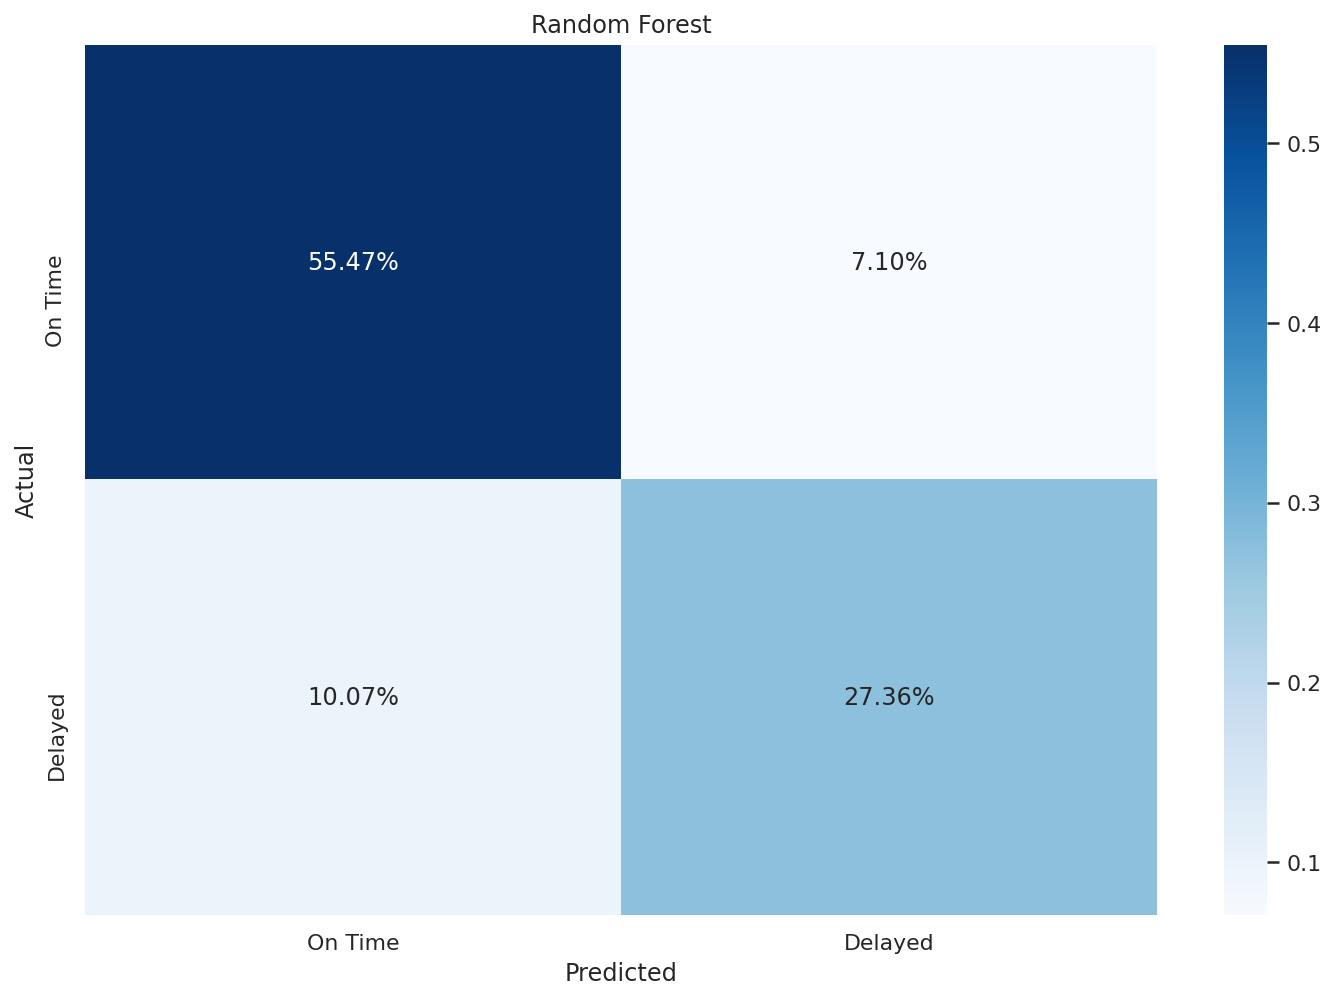

In [37]:
# Plot confusion matrix
print('Model F1 Score: %.3f' % f1_score(y_test,y_pred))

cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues',xticklabels=['On Time','Delayed'],yticklabels=['On Time','Delayed'])
plt.title('Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Save Deployment Assets

We now need to save our deployment assets to Db2. They include:
- Our trained ML pipeline, saved as a joblib file and stored in a Db2 table
- Our custom transformers, saved as a Python script and stored on the shared filesystem 

#### Save our ML pipeline to a Db2 table

1. Save our asset as a joblib file
2. Create a table MYASSETS for storing the contents of the joblib file
3. Use the ibm_db package to store the contents of the joblib file to the MYASSETS table

In [38]:
# Save our asset as a joblib file
dump(trained_pipeline,'../../../PYUDF/trained_pipeline.joblib')

['../../../PYUDF/trained_pipeline.joblib']

In [39]:
%%sql
DROP TABLE IF EXISTS MYASSETS

Command completed.


In [40]:
%%sql
CREATE TABLE MYASSETS(name VARCHAR(15),joblib BLOB) 

Command completed.


In [41]:
# Custom function for saving the contents of a joblib file to a Db2 table
def deploy_joblib_assets(asset_name,filepath,table_name,ibm_db_conn):
    '''
    asset_name = name of the asset - to be stored in Db2 table column
    filepath = the path to the joblib file to be stored
    table_name = the Db2 table which will store the joblib file contents and the asset name
    ibm_db_conn = an connection to the Db2 database created by the ibm_db.connect() function
    '''
    
    joblib_file=filepath
    name=asset_name

    print("Preparing to deploy asset "+asset_name+" to Db2...")
    
    # Prepare SQL INSERT statement
    insert_sql = "INSERT INTO "+table_name+"(name,joblib) values(?,?)"
    stmt = ibm_db.prepare(ibm_db_conn, insert_sql)
    print("Successfully prepared the insert statement")
    
    # Bind parameters (name & joblib file contents) to the placeholders
    rc = ibm_db.bind_param(stmt, 1, name)
    print("Bind returned: "+str(rc))
    rc = ibm_db.bind_param(stmt, 2, joblib_file, ibm_db.PARAM_FILE,ibm_db.SQL_BLOB )
    print("Bind returned: "+str(rc))
    print("Successfully bound the variables to the parmameter-markers")
    
    # Execute the INSERT statement
    try:
        ibm_db.execute(stmt)
        print("Successfully inserted joblib file into blob column\n")
    except:
        print("Failed to execute the insert to blob column")
        print(ibm_db.stmt_errormsg(stmt))


In [42]:
# Make a connection to the Db2 database - for use in our custom function
conn_str = "DATABASE=ONTIME;" + \
           "HOSTNAME=localhost;"+ \
           "PROTOCOL=TCPIP;"  + \
           "PORT=50001;" + \
           "UID=db2inst1;" + \
           "PWD=db2inst1;"

ibm_db_conn = ibm_db.connect(conn_str,"","")
print('Connection to Db2 Instance Created!')

Connection to Db2 Instance Created!


In [43]:
# Save our asset to the MYASSETS table
deploy_joblib_assets("pipeline","../../../PYUDF/trained_pipeline.joblib","MYASSETS",ibm_db_conn)

Preparing to deploy asset pipeline to Db2...
Successfully prepared the insert statement
Bind returned: True
Bind returned: True
Successfully bound the variables to the parmameter-markers
Successfully inserted joblib file into blob column



#### Saving our custom functions

We will simply create a python script `mycustomtransformers.py` that we will use to load in our custom transformers into our UDF in a later step

In [44]:
%%writefile ../../../PYUDF/mycustomtransformers.py

import numpy as np 
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin


#Custom transformer that breaks time values into categorical values
class TimeTransformer( BaseEstimator, TransformerMixin ):
    #Class constructor method - takes no inputs, so nothing to do
    def __init__(self):
        return None
        
    #Return self nothing else to do here
    def fit( self, X, y = None  ):
        return self
    
    #Transformer method we wrote for this transformer 
    # Converts 24hr features into 4 quarters of the day, splits elapsed time into 30min segments
    def transform(self, X , y = None ):
        X['CRSDEPTIME'] = np.ceil(X['CRSDEPTIME']/600).apply(int)
        X['WHEELSOFF'] = np.ceil(X['WHEELSOFF']/600).apply(int) 
        X['CRSARRTIME'] = np.ceil(X['CRSARRTIME']/600).apply(int)
        X['CRSELAPSEDTIME']=np.ceil(X['CRSELAPSEDTIME']/30).apply(int)
        
        return X.values 


#Custom transformer that reduces the number of unique values
class ReduceUnique( BaseEstimator, TransformerMixin ):
    #Class constructor method - takes no inputs, so nothing to do
    def __init__(self):
        return None
        
    #Fit method - find the top 10 most common occurrences in each of the 3 columns
    def fit( self, X, y = None  ):
        self._top_10_airlines = X_train['UNIQUECARRIER'].value_counts().index[:10].tolist()
        self._top_10_origin = X_train['ORIGIN'].value_counts().index[:10].tolist()
        self._top_10_dest = X_train['DEST'].value_counts().index[:10].tolist()
        return self
    
    #Transformer method - convert values not in the top 10 lists to "Other_X"
    def transform(self, X , y = None ):
        X['UNIQUECARRIER'] = np.where(~X['UNIQUECARRIER'].isin(self._top_10_airlines),
                                      'Other_Airline', X['UNIQUECARRIER'])
        X['ORIGIN'] = np.where(~X['ORIGIN'].isin(self._top_10_origin),'Other_Origin', X['ORIGIN'])
        X['DEST'] = np.where(~X['DEST'].isin(self._top_10_dest),'Other_Dest', X['DEST'])
        
        return X.values 

Overwriting ../../../PYUDF/mycustomtransformers.py


# Part II. Deploying the Pipeline to Db2

We are now ready to deploy our model to Db2 for in-database scoring.

We will:
1. Create a UDF source file
2. Register our Python UDF
3. Call our UDF with a SQL statement

Our UDF (User Defined Function) has the following sections:
- **Initialization**: Define any static variables, load our deployment assets (e.g. model), and prepare for batch scoring
- **Data Preparation**: Perform the same data preparation steps we performed during model development
- **Model Scoring & Output**: Call our model to make predictions and return the results

Our UDF will output the following:
- `DATE`: The date of the flight 
- `ORIGIN`: The origin airport
- `DEST`: The destination airport
- `CARRIER`: The airline code
- `CRSDEPTIME`: The scheduled departure time
- `CRSARRTIME`: The scheduled arrival time 
- `PREDICTION`: The prediction (0 = on time, 1 = delayed)
- `PROB_DELAYED`: The predicted probability that the flight will be delayed

![](media/udfdeployment.png)

**Figure 4**: This figure depicts how a UDF source file is created from the original pipeline code developed during the model development stage.

In [45]:
%%writefile ../../../PYUDF/myUDF.py

#Imports
import nzae
import pandas as pd
from joblib import load
import numpy as np
import ibm_db
from io import BytesIO
sys.path.insert(0, 'home/db2inst1/PYUDF/')
from mycustomtransformers import TimeTransformer, ReduceUnique

class full_pipeline(nzae.Ae):
    def _runUdtf(self):
        #####################
        ### INITIALIZATON ###
        #####################
        
        # Define static variables
        input_cols = ['YEAR','QUARTER', 'MONTH',
                      'DAYOFMONTH', 'DAYOFWEEK','UNIQUECARRIER',
                      'ORIGIN', 'DEST', 'CRSDEPTIME',
                      'DEPDELAY', 'DEPDEL15','TAXIOUT','WHEELSOFF',
                      'CRSARRTIME', 'CRSELAPSEDTIME', 'AIRTIME', 'DISTANCEGROUP']

        # Make a connection to our Db2 database - for executing SQL statements
        conn_str = "DATABASE=ONTIME;" + \
           "HOSTNAME=localhost;"+ \
           "PROTOCOL=TCPIP;"  + \
           "PORT=50001;" + \
           "UID=db2inst1;" + \
           "PWD=db2inst1;"

        ibm_db_conn = ibm_db.connect(conn_str,"","")
        
        # Load our trained ML pipeline
        sql = "SELECT JOBLIB FROM MYASSETS WHERE NAME='pipeline'"
        stmt = ibm_db.exec_immediate(ibm_db_conn, sql)
        row = ibm_db.fetch_tuple(stmt)
        trained_pipeline = load(BytesIO(row[0]))
        
        #######################
        ### DATA COLLECTION ###
        #######################
        # Collect rows into a single batch
        batchsize = 10000
        rownum = 0
        row_list = []
        for row in self:
            row_list.append(row)
            rownum = rownum+1         

            if rownum==batchsize:

                # Create a dataframe from the batch
                df = pd.DataFrame(row_list, columns=input_cols)

                # Save the original datestring (yyyymmdd), ORIGIN, DEST, UNIQUECARRIER, CRSDEPTIME, CRSARRTIME
                # to return with the model prediction
                dates = [int(year + month + day) for year, month, day in 
                         zip(map(str,list(df['YEAR'])), map(str,["%02d" %i for i in list(df['MONTH'])]), 
                             map(str,["%02d" %i for i in list(df['DAYOFMONTH'])]))]
                origins = list(df['ORIGIN'])
                dests = list(df['DEST'])
                carriers = list(df['UNIQUECARRIER'])
                deptimes = list(df['CRSDEPTIME'])
                arrtimes = list(df['CRSARRTIME'])

                ##############################
                ### MODEL SCORING & OUTPUT ###
                ##############################
                
                # Call our trained pipeline to transform the data and make predictions
                predictions = trained_pipeline.predict(df)
                
                # Calculate probability that flight will be delayed, round to 2 decimal places              
                probability_delayed = [round(x,2) for x in trained_pipeline.predict_proba(df)[:,1]]

                # Return the result
                for x in range(predictions.shape[0]):
                    self.output(int(dates[x]),str(origins[x]),str(dests[x]),str(carriers[x]),
                                int(deptimes[x]),int(arrtimes[x]),int(predictions[x]),
                                float(probability_delayed[x]))

                row_list = []
                rownum = 0
                
        self.done()
full_pipeline.run()

Overwriting ../../../PYUDF/myUDF.py


We are now ready to register our UDF. We will provide it a name `FLIGHT_PREDICTER`, define the input datatypes, the definition of the table it outputs (i.e. column names and datatypes), and the path to our source file.

In [46]:
%%sql
CREATE OR REPLACE FUNCTION 
FLIGHT_PREDICTER(SMALLINT,SMALLINT,SMALLINT,SMALLINT,SMALLINT,VARCHAR(8),VARCHAR(3),VARCHAR(3),SMALLINT,
                 SMALLINT,SMALLINT,SMALLINT,SMALLINT,SMALLINT,SMALLINT,SMALLINT,SMALLINT) 
RETURNS TABLE (DATE INTEGER,ORIGIN VARCHAR(3), DEST VARCHAR(3), CARRIER VARCHAR(3), 
CRSDEPTIME SMALLINT, CRSARRTIME SMALLINT,PREDICTION SMALLINT,PROB_DELAYED DOUBLE)
LANGUAGE PYTHON PARAMETER STYLE NPSGENERIC  FENCED  NOT THREADSAFE  NO FINAL CALL  DISALLOW PARALLEL  NO DBINFO  
DETERMINISTIC NO EXTERNAL ACTION CALLED ON NULL INPUT  
NO SQL EXTERNAL NAME 'home/db2inst1/PYUDF/myUDF.py'

Command completed.


With our UDF source file created and our function registered, we can now call the Python UDF to make predictions. We will create a table `ONTIME.PREDICTIONS` to store the results, and insert the output from our UDF into that table. Recall that we will be making predictions on new flight data from 2020 (i.e., the model is using historical data to make predictions on future events).

In [47]:
%%sql
DROP TABLE IF EXISTS ONTIME.PREDICTIONS

Command completed.


In [48]:
%%sql
CREATE TABLE ONTIME.PREDICTIONS(DATE INTEGER,
                                ORIGIN VARCHAR(3), 
                                DEST VARCHAR(3),
                                CARRIER VARCHAR(3),
                                CRSDEPTIME SMALLINT, 
                                CRSARRTIME SMALLINT,
                                PREDICTION SMALLINT,
                                PROB_DELAYED DOUBLE)

Command completed.


In [49]:
%%sql
INSERT INTO ONTIME.PREDICTIONS(DATE,ORIGIN,DEST,CARRIER,CRSDEPTIME,CRSARRTIME,PREDICTION,PROB_DELAYED)
SELECT f.* from ONTIME.NEWDATA i,
TABLE(FLIGHT_PREDICTER(i.YEAR, i.QUARTER, i.MONTH, 
                i.DAYOFMONTH, i.DAYOFWEEK,i.UNIQUECARRIER,
                i.ORIGIN, i.DEST, i.CRSDEPTIME,
                i.DEPDELAY, i.DEPDEL15,i.TAXIOUT,i.WHEELSOFF,
                i.CRSARRTIME, i.CRSELAPSEDTIME, i.AIRTIME, i.DISTANCEGROUP)) f

Command completed.


Finally, we can query the `ONTIME.PREDICTIONS` table to look at the output.

In [50]:
query = %sql SELECT * FROM ONTIME.PREDICTIONS
result = pd.DataFrame(query)

In [51]:
# Lets look at the first 10 rows of our UDF's output
result.head(10)

,DATE,ORIGIN,DEST,CARRIER,CRSDEPTIME,CRSARRTIME,PREDICTION,PROB_DELAYED
0,20200627,ATL,MCI,FL,1731,1836,0,0.15
1,20200703,EWR,LAS,CO,745,1010,0,0.29
2,20200322,ATL,LGA,DL,1745,2007,0,0.18
3,20200115,MCO,DFW,AA,1935,2130,1,0.75
4,20200716,ISN,MSP,OO,640,824,0,0.21
5,20200608,BNA,DTW,DL,1315,1552,0,0.15
6,20200729,IAH,MCO,UA,1555,1918,1,0.78
7,20200312,PIA,CLT,OH,730,1035,1,1.00
8,20200330,DFW,LIT,MQ,659,811,1,1.00
9,20200523,DFW,MIA,AA,1040,1431,1,1.00


## Exercise: Build and deploy your own UDF

In this exercise you will deploy your own ML classification model. We will provide the steps to build and deploy the model, including any necessary data transformation steps. You will be responsible for filling the UDF template provided during the model deployment phase.

The dataset used is the famous IRIS dataset - it contains samples from each of three species of *Iris* flowers. (*Iris setosa*, *Iris virginica*, and *Iris versicolor*). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters.

In [52]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np

# Model building
from sklearn.model_selection import train_test_split # Train-test split
from sklearn.impute import SimpleImputer # Missing values imputation
from sklearn.compose import ColumnTransformer # For applying transformation objects
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score # Model evaluation
from joblib import dump #Saving deployment assets

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(12,8)})
%config InlineBackend.figure_format = 'retina'

First load the Db2 magic functions and make a connection to our Db2 database.

In [53]:
%run db2.ipynb

Db2 Extensions Loaded.


In [54]:
%run connectiondb2ml.ipynb

Connection successful.


### Data Exploration

In [55]:
# Let's look at the training data
query = %sql SELECT * FROM ONTIME.IRIS_TRAIN
df = pd.DataFrame(query)
df.head(10)

,ID,SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH,CLASS
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
5,6,NaN,3.9,1.7,0.4,Iris-setosa
6,7,4.6,3.4,1.4,0.3,Iris-setosa
7,8,5.0,3.4,1.5,0.2,Iris-setosa
8,9,4.4,2.9,1.4,NaN,Iris-setosa
9,10,4.9,3.1,1.5,0.1,Iris-setosa


In [56]:
# First drop the ID column as it is only a row identifier
df=df.drop("ID",axis=1)

# Train test split
target = "CLASS"
X = df.drop(target,axis=1)
y = df[target]

# Our dataset size is small, so we will do a 70/30 train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [57]:
print('The training dataset has',X_train.shape[0],'rows and',X_train.shape[1],'columns.')

The training dataset has 105 rows and 4 columns.


In [58]:
print('The test dataset has',X_test.shape[0],'rows and',X_test.shape[1],'columns.')

The test dataset has 45 rows and 4 columns.


### Data Transformation

Let's check for missing values in our training and test sets, and perform imputation if necessary.

In [59]:
# Count the number of missing values in the training set
number_of_missing_vals = X_train.isna().sum()
number_of_missing_vals

SEPAL_LENGTH    4
SEPAL_WIDTH     3
PETAL_LENGTH    2
PETAL_WIDTH     5
dtype: int64

Next, let's perform missing value imputation

In [60]:
#Create pipeline
pipeline = Pipeline([('imputer',SimpleImputer(strategy='mean')), #Impute missing values
                    ('model',DecisionTreeClassifier(random_state=42))]) #Decision Tree model

Now, let's repeat these steps for our test set

### Model Training and Evaluation

We will train a simple decision tree model to predict the type of flower based on the sepal and petal length and width.

In [61]:
# Transform the data and fit our ML model
fitted_pipe=pipeline.fit(X_train,y_train)

In [62]:
# Make predictions on the test set to evaluate the model performance
y_pred = fitted_pipe.predict(X_test)

We next will make predictions on our test set and evaluate the performance of the model

Model F1 Score: 1.000


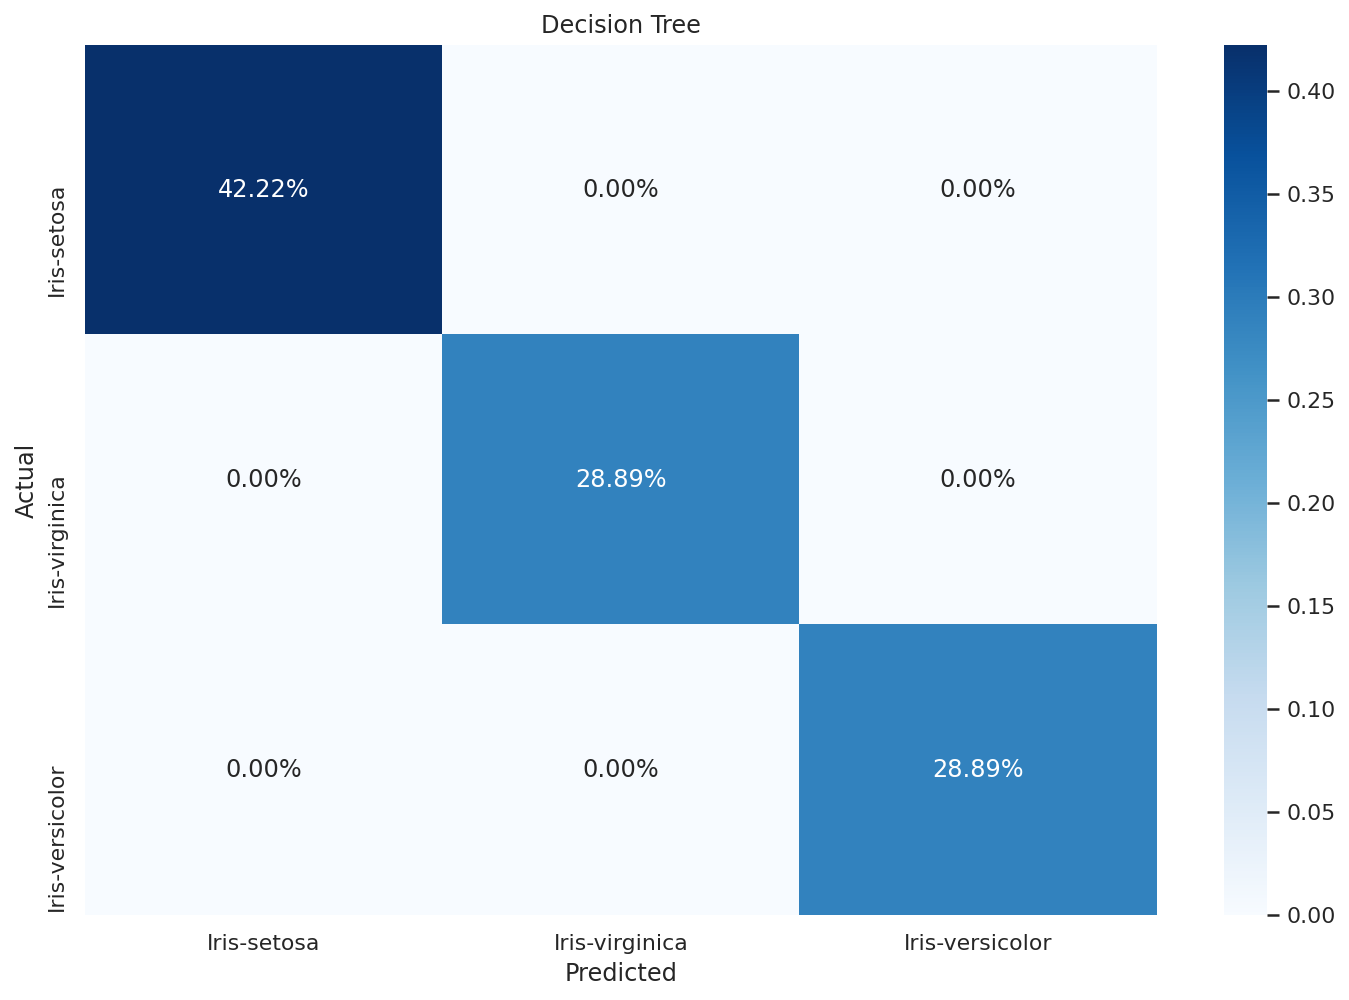

In [63]:
# Plot confusion matrix
print('Model F1 Score: %.3f' % f1_score(y_test,y_pred,average='weighted'))

cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues',xticklabels=['Iris-setosa','Iris-virginica','Iris-versicolor'],
            yticklabels=['Iris-setosa','Iris-virginica','Iris-versicolor'])
plt.title('Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Save Deployment Assets

Once we are satisfied with our model, we will save the trained imputer and trained model to the shared filesystem

In [64]:
# Save our model and scalar
dump(fitted_pipe,"../../../PYUDF/exercise_pipeline.joblib")

['../../../PYUDF/exercise_pipeline.joblib']

In [65]:
%%sql
DROP TABLE IF EXISTS MYASSETS

Command completed.


In [66]:
%%sql
CREATE TABLE MYASSETS(name VARCHAR(15),joblib BLOB) 

Command completed.


In [67]:
deploy_joblib_assets("mypipeline","../../../PYUDF/exercise_pipeline.joblib","MYASSETS",ibm_db_conn)

Preparing to deploy asset mypipeline to Db2...
Successfully prepared the insert statement
Bind returned: True
Bind returned: True
Successfully bound the variables to the parmameter-markers
Successfully inserted joblib file into blob column



### Model Deployment

Here, we have provided a UDF template for you to fill out.

1. Write a SQL statment to load in the pipeline from the MYASSETS table (line 28)
2. Add some code to make predictions with the ML pipeline (line 60)

In [68]:
%%writefile ../../../PYUDF/exerciseUDF.py

#Imports
import nzae
import pandas as pd
from joblib import load
import numpy as np
import ibm_db
from io import BytesIO

class full_pipeline(nzae.Ae):
    def _runUdtf(self):
        #####################
        ### INITIALIZATON ###
        #####################
        
        # Load deployment assets from Db2 tables
        conn_str = "DATABASE=ONTIME;" + \
           "HOSTNAME=localhost;"+ \
           "PROTOCOL=TCPIP;"  + \
           "PORT=50001;" + \
           "UID=db2inst1;" + \
           "PWD=db2inst1;"

        ibm_db_conn = ibm_db.connect(conn_str,"","")
        
        # Load ML pipeline
        sql = "SELECT JOBLIB FROM MYASSETS WHERE NAME='mypipeline'"
        stmt = ibm_db.exec_immediate(ibm_db_conn, sql)
        row = ibm_db.fetch_tuple(stmt)
        pipeline = load(BytesIO(row[0]))

        # Define static variable
        input_cols=['SEPAL_LENGTH','SEPAL_WIDTH','PETAL_LENGTH','PETAL_WIDTH']
     
        # Collect rows into a single batch
        batchsize = 110
        rownum = 0
        row_list = []
        for row in self:
            row_list.append(row)
            rownum = rownum+1         

            if rownum==batchsize:
                ########################
                ### DATA PREPARATION ###
                ########################
                
                # Separate the IDs out for returning with the predictions
                ids=np.array(row_list)[:,0]
                
                # Collect the rows into a dataframe
                df = pd.DataFrame(np.array(row_list)[:,1:5], columns=input_cols)

                ##############################
                ### MODEL SCORING & OUTPUT ###
                ##############################
                
                # Call model to make prediction
                predictions = pipeline.predict(df)
                
                # Return the result
                for x in range(predictions.shape[0]):
                    self.output(int(ids[x]),str(predictions[x]))

                row_list = []
                rownum = 0      
        self.done()
full_pipeline.run()

Overwriting ../../../PYUDF/exerciseUDF.py


Now, run the following cells to check your work. **Hint:** If you encounter errors, the UDF log files can be found in the `sqllib/db2dump/pythonUDX/` directory.

In [69]:
%%sql
CREATE OR REPLACE FUNCTION 
MY_UDF(INT,DOUBLE,DOUBLE,DOUBLE,DOUBLE) 
RETURNS TABLE (ID INT,PREDICTION VARCHAR(15))
LANGUAGE PYTHON PARAMETER STYLE NPSGENERIC  FENCED  NOT THREADSAFE  NO FINAL CALL  DISALLOW PARALLEL  NO DBINFO  
DETERMINISTIC NO EXTERNAL ACTION CALLED ON NULL INPUT  
NO SQL EXTERNAL NAME 'home/db2inst1/PYUDF/exerciseUDF.py'

Command completed.


In [70]:
%%sql
DROP TABLE IF EXISTS ONTIME.IRIS_PREDICTIONS

Command completed.


In [71]:
%%sql
CREATE TABLE ONTIME.IRIS_PREDICTIONS(ID INT,PREDICTION VARCHAR(15))

Command completed.


In [72]:
%%time
%%sql
INSERT INTO ONTIME.IRIS_PREDICTIONS(ID,PREDICTION)
SELECT f.* from ONTIME.IRIS_TEST i,
TABLE(MY_UDF(i.ID,i.SEPAL_LENGTH,i.SEPAL_WIDTH,i.PETAL_LENGTH,i.PETAL_WIDTH)) f

Command completed.
CPU times: user 902 µs, sys: 1.4 ms, total: 2.3 ms
Wall time: 1.98 s


In [73]:
query = %sql SELECT * FROM ONTIME.IRIS_PREDICTIONS
result = pd.DataFrame(query)
result.head(10)

,ID,PREDICTION
0,1,Iris-setosa
1,2,Iris-setosa
2,3,Iris-setosa
3,4,Iris-setosa
4,5,Iris-setosa
5,6,Iris-setosa
6,7,Iris-setosa
7,8,Iris-setosa
8,9,Iris-setosa
9,10,Iris-setosa


## Resources

[Video: Deploying a Machine Learning Model Trained on IBM Cloud Pak for Data into Db2](https://video.ibm.com/recorded/129516812)